## Marmousi2 model 


Gary S. Martin, Robert Wiley, and Kurt J. Marfurt, (2006), "Marmousi2: An elastic upgrade for Marmousi," The Leading Edge 25: 156-166. https://library.seg.org/doi/10.1190/1.2172306

The raw data can be downloaded from [this website](http://www.agl.uh.edu/downloads/downloads.htm)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp2d
import scipy.signal
import scipy.io
import obspy
import os
from util import *

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
in_dir = "./models_raw/"
out_dir = "./models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [41]:
def extract_data(meta):
    data = []
    for trace in meta:
        data.append(trace.data)
    return np.array(data)

In [42]:
def load_marmousi_model():
    if not os.path.exists(os.path.join(in_dir, "vp_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vp_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "vs_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vs_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "rho_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/density_marmousi-ii.segy.gz", in_dir))
    meta = obspy.read(os.path.join(in_dir, "vs_marmousi-ii.segy.gz"), format='segy')
    vs = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "vp_marmousi-ii.segy.gz"), format='segy')
    vp = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "density_marmousi-ii.segy.gz"), format='segy')
    rho = extract_data(meta) * 1e3 #kg/m^3
    
    x_range = [0, 17000] #m
    y_range = [0, 3500] #m
    nx, ny = vp.shape
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)

    marmousi_model = {}
    marmousi_model['vp'] = vp
    marmousi_model['vs'] = vs
    marmousi_model['rho'] = rho
    marmousi_model['x'] = x
    marmousi_model['y'] = y
    marmousi_model['dx'] = x[1] - x[0]
    marmousi_model['dy'] = y[1] - y[0]
    
    return marmousi_model

marmousi_model = load_marmousi_model()

In [57]:
def resample_model(x, y, model):
    
    vs = interp2d(model['y'], model['x'], model['vs'], kind='cubic')(y, x)
    vp = interp2d(model['y'], model['x'], model['vp'], kind='cubic')(y, x)
    rho = interp2d(model['y'], model['x'], model['rho'], kind='cubic')(y, x)
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = x
    new_model['y'] = y
    new_model['dx'] = x[1] - x[0]
    new_model['dy'] = y[1] - y[0]
    
    return new_model
    

f0 = 15
vp0 = np.max(marmousi_model['vp'])
dx, dt = calc_dx_dt(f0, vp0)
dy = dx
dx *= 1.5
dy *= 1.5
dt *= 2
n_pml = 11
x_range = [5000, 13000]
y_range = [0, 3500]
t_range = [0, np.sqrt((x_range[1] - x_range[0])**2 + (y_range[1] - y_range[0])**2)/np.mean(marmousi_model['vp']) * 1.2]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
t = np.arange(t_range[0], t_range[1], dt)
nx = len(x)
ny = len(y)
nt = len(t)
model = resample_model(x, y, marmousi_model)
src_rcv_depth = n_pml
mask_extra_detph = 0
print("nx = {}, ny = {}, nt = {}".format(nx, ny, nt))
print("dx = {} m, dy = {} m, dt = {} s".format(dx, dy, dt))

nx = 120, ny = 53, nt = 618
dx = 67.14285714285714 m, dy = 67.14285714285714 m, dt = 0.006349206349206348 s


In [58]:
def add_source(nsrc, nx, nt, dt, f0=5, n_pml=0):
    src_list = []
    src_ix = np.round(np.linspace(0+2*n_pml, nx-2*n_pml, nsrc)).astype('int')
    src_iy = np.ones_like(src_ix) * src_rcv_depth
    src_vec = np.zeros(nt)
    vec = 1e7*ricker(f0, dt)
    src_vec[:len(vec)] = vec[:nt]
    for i in range(nsrc):
        tmp = {}
        tmp['ix'] = src_ix[i]
        tmp['iy'] = src_iy[i]
        tmp['type'] = 0
        tmp['vec'] = src_vec
        src_list.append(tmp)
    return src_list

nsrc = 8
source_list = add_source(nsrc, nx, nt, dt, f0, n_pml)

In [77]:
def add_receiver(nrcv, nsrc, nx, n_pml=0, full=False):
    rcv = {}
    if full:
      rcv['ix'] = np.arange(n_pml, nx-n_pml+1).astype('int')
    else:
      rcv['ix'] = np.round(np.linspace(0+n_pml, nx-n_pml, nrcv)).astype('int')
    rcv['iy'] = np.ones_like(rcv['ix']) * src_rcv_depth
    rcv['type'] = np.ones_like(rcv['ix'])
    rcv_list = [rcv] * nsrc
    return rcv_list

receiver_list = add_receiver(int(vp0/f0/dx)*3, nsrc, nx, n_pml, True)

In [78]:
def get_smooth_model(model, src):
    if mask_extra_detph > 0:
        vp = model['vp'].copy()
        vp[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['vp'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
        vs = model['vs'].copy()
        vs[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['vs'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
        rho = model['rho'].copy()
        rho[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['rho'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
    else:
        vp = model['vp'].copy()
        vp = gaussian_filter(model['vp'], [10,10], mode='reflect')
        vs = model['vs'].copy()
        vs = gaussian_filter(model['vs'], [10,10], mode='reflect')
        rho = model['rho'].copy()
        rho = gaussian_filter(model['rho'], [10,10], mode='reflect')
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = model['x']
    new_model['y'] = model['y']
    new_model['dx'] = model['dx']
    new_model['dy'] = model['dy']
    return new_model

smooth_model = get_smooth_model(model, source_list[0])

<IPython.core.display.Javascript object>


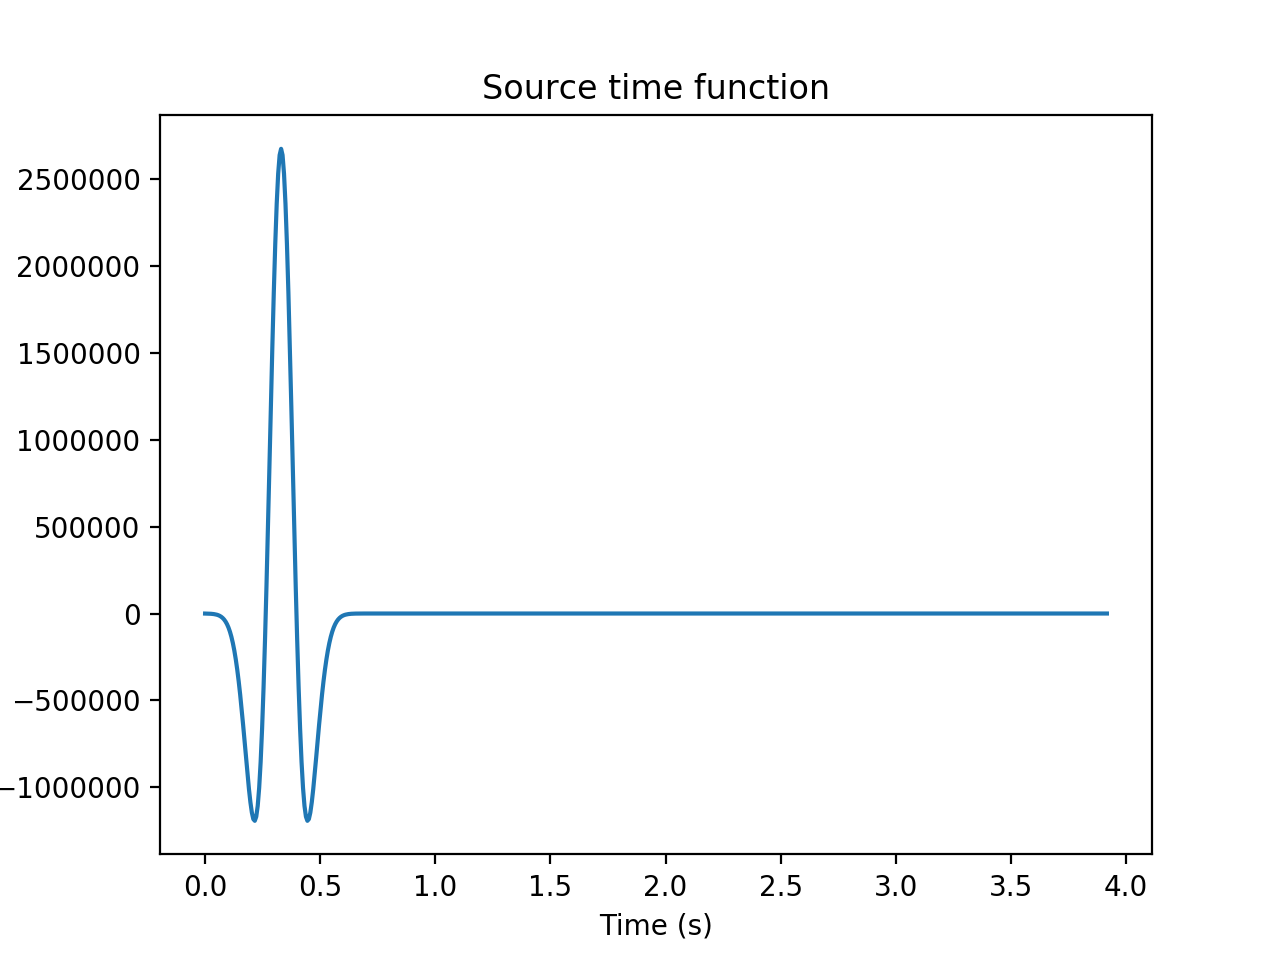

In [79]:
plt.figure()
plt.plot(t, source_list[0]['vec'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Source time function")
plt.show()

<IPython.core.display.Javascript object>


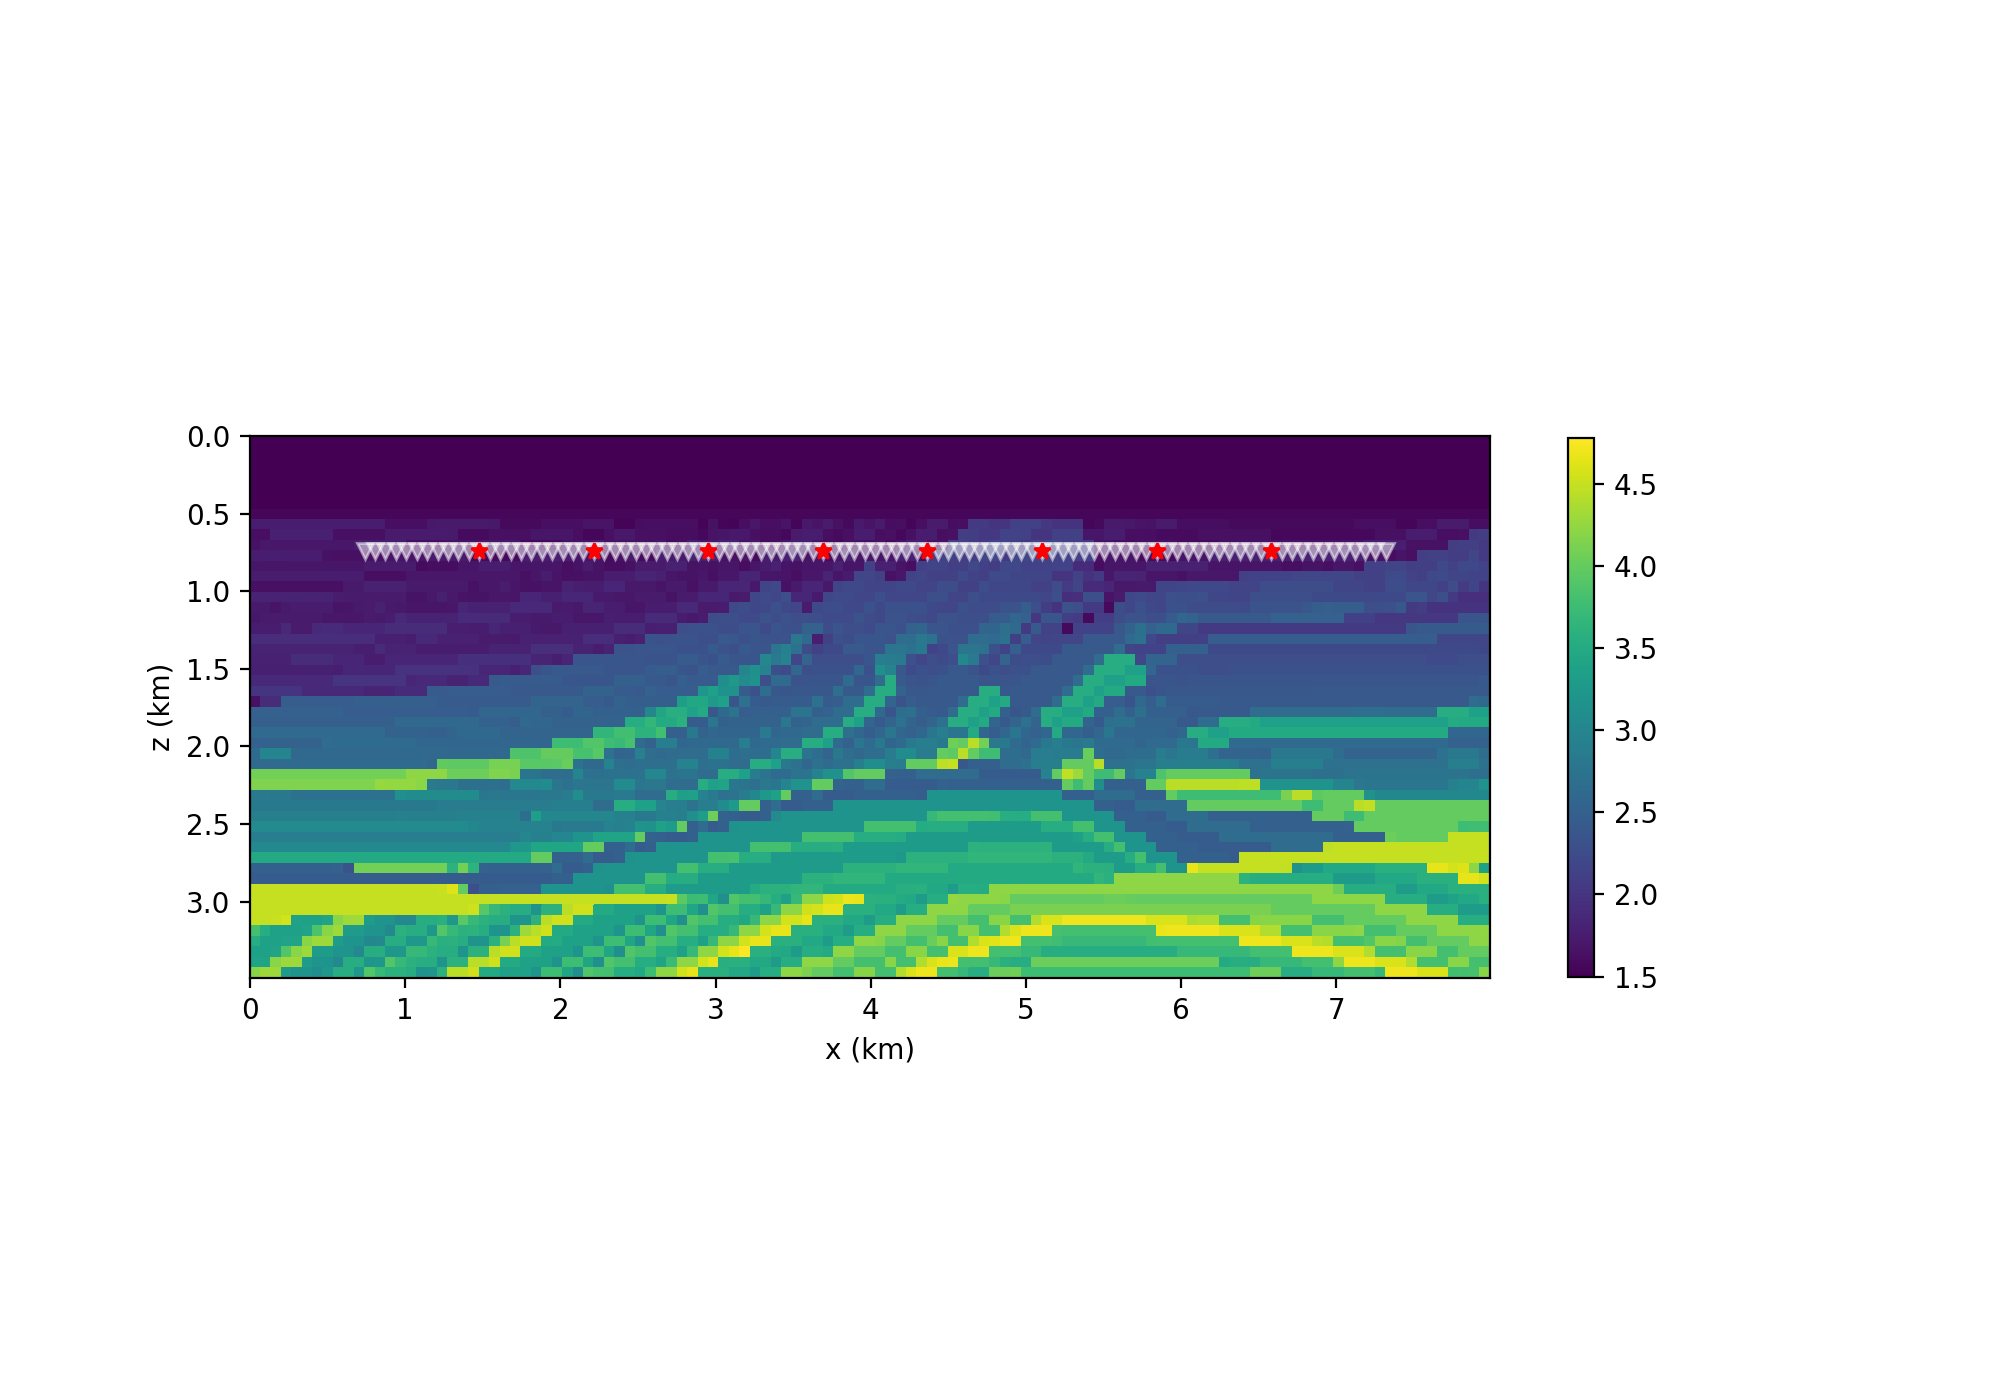

In [80]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vp'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-vp.png"))
plt.show()

<IPython.core.display.Javascript object>


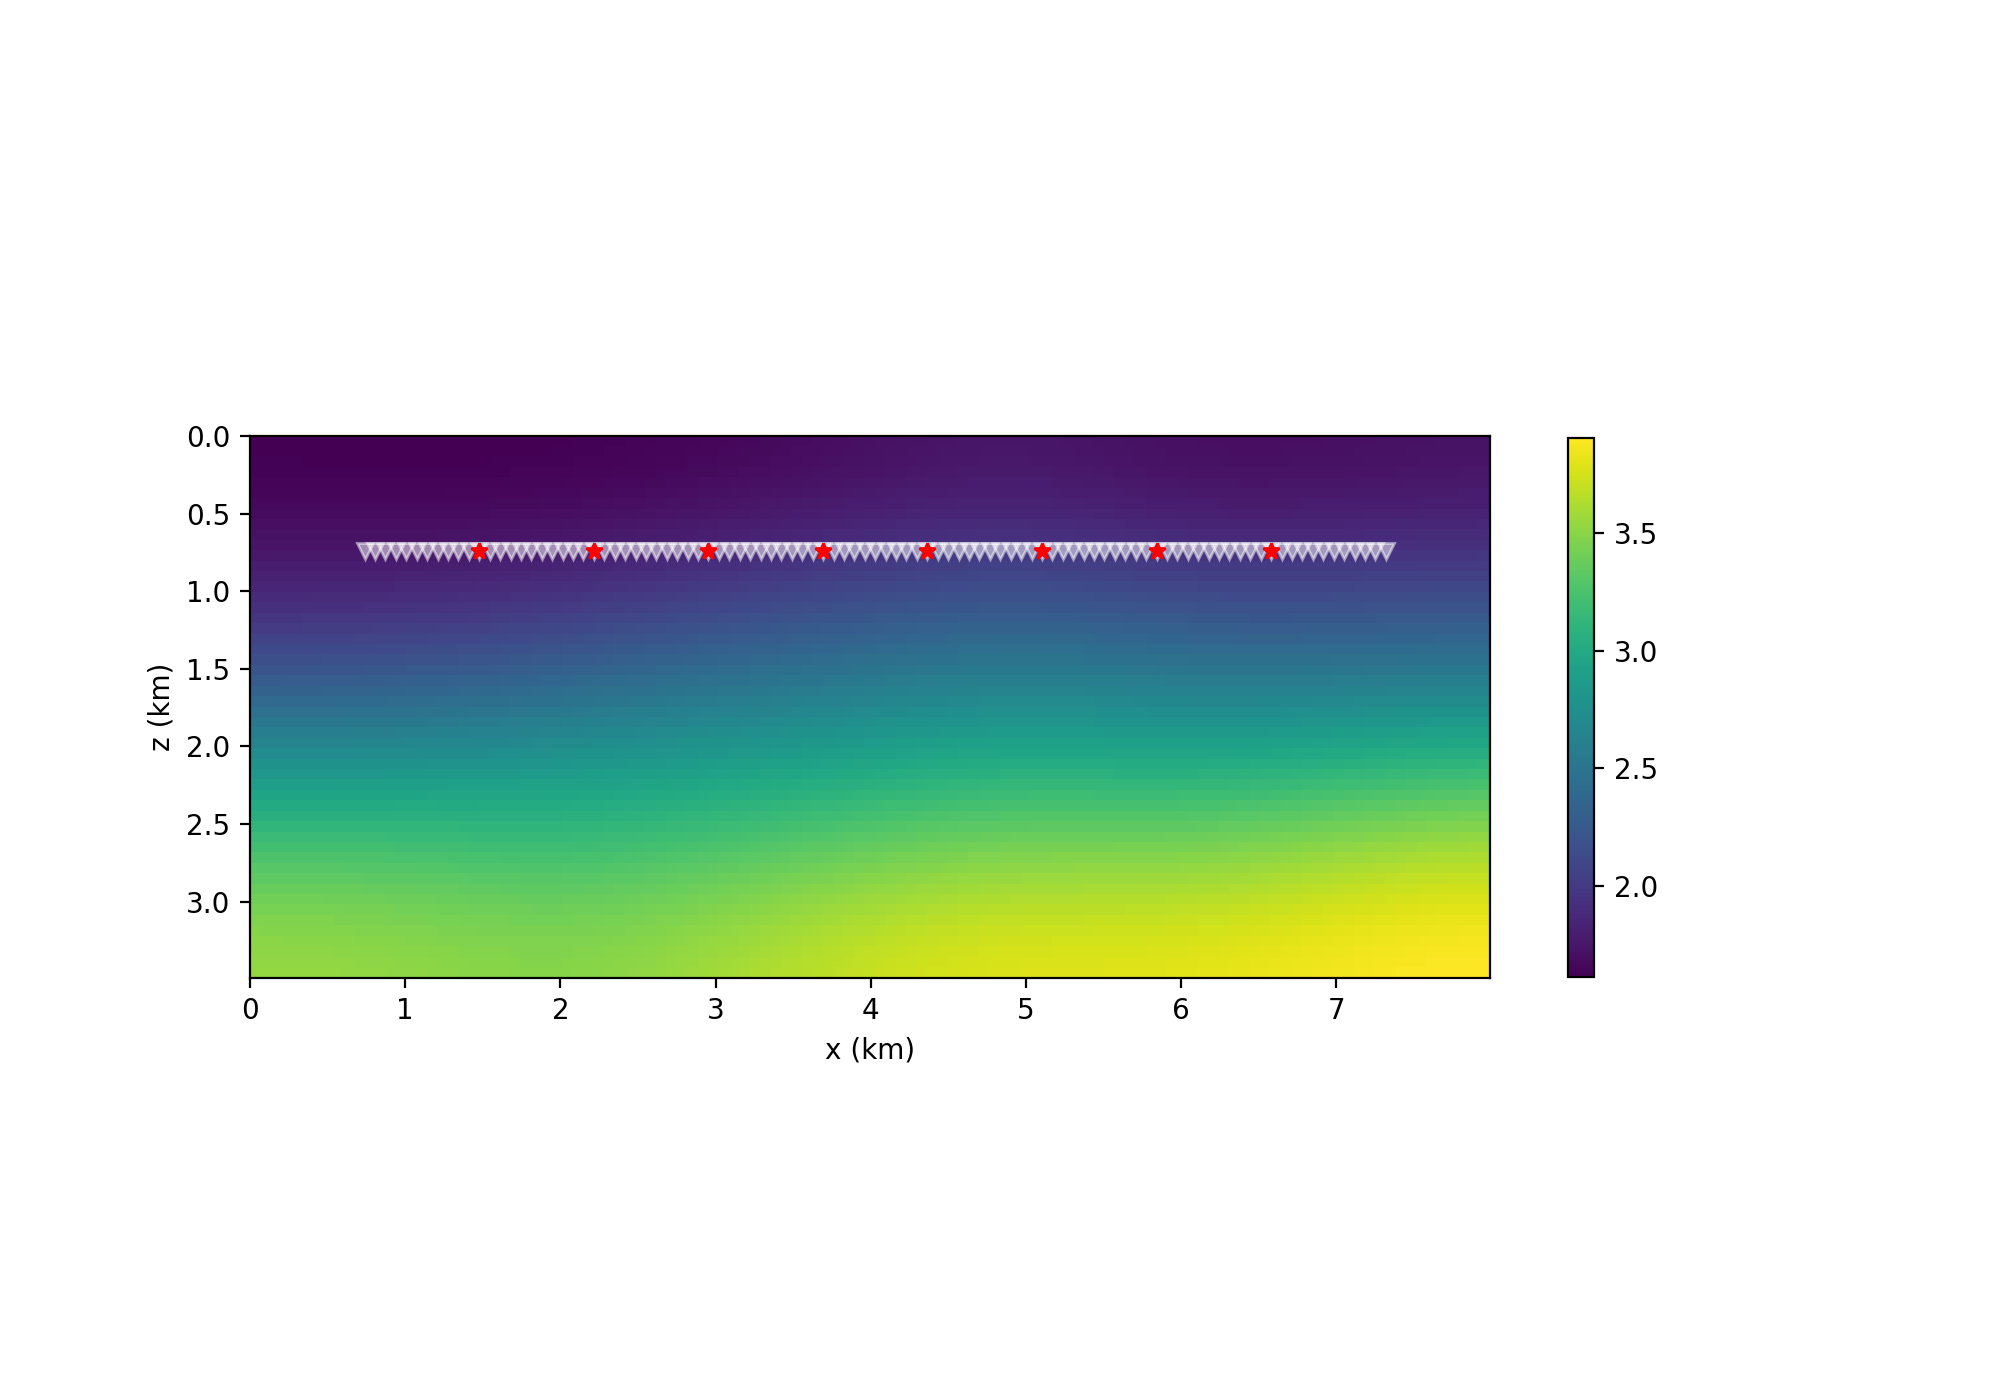

In [81]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['vp'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-smooth-vp.png"))
plt.show()

<IPython.core.display.Javascript object>


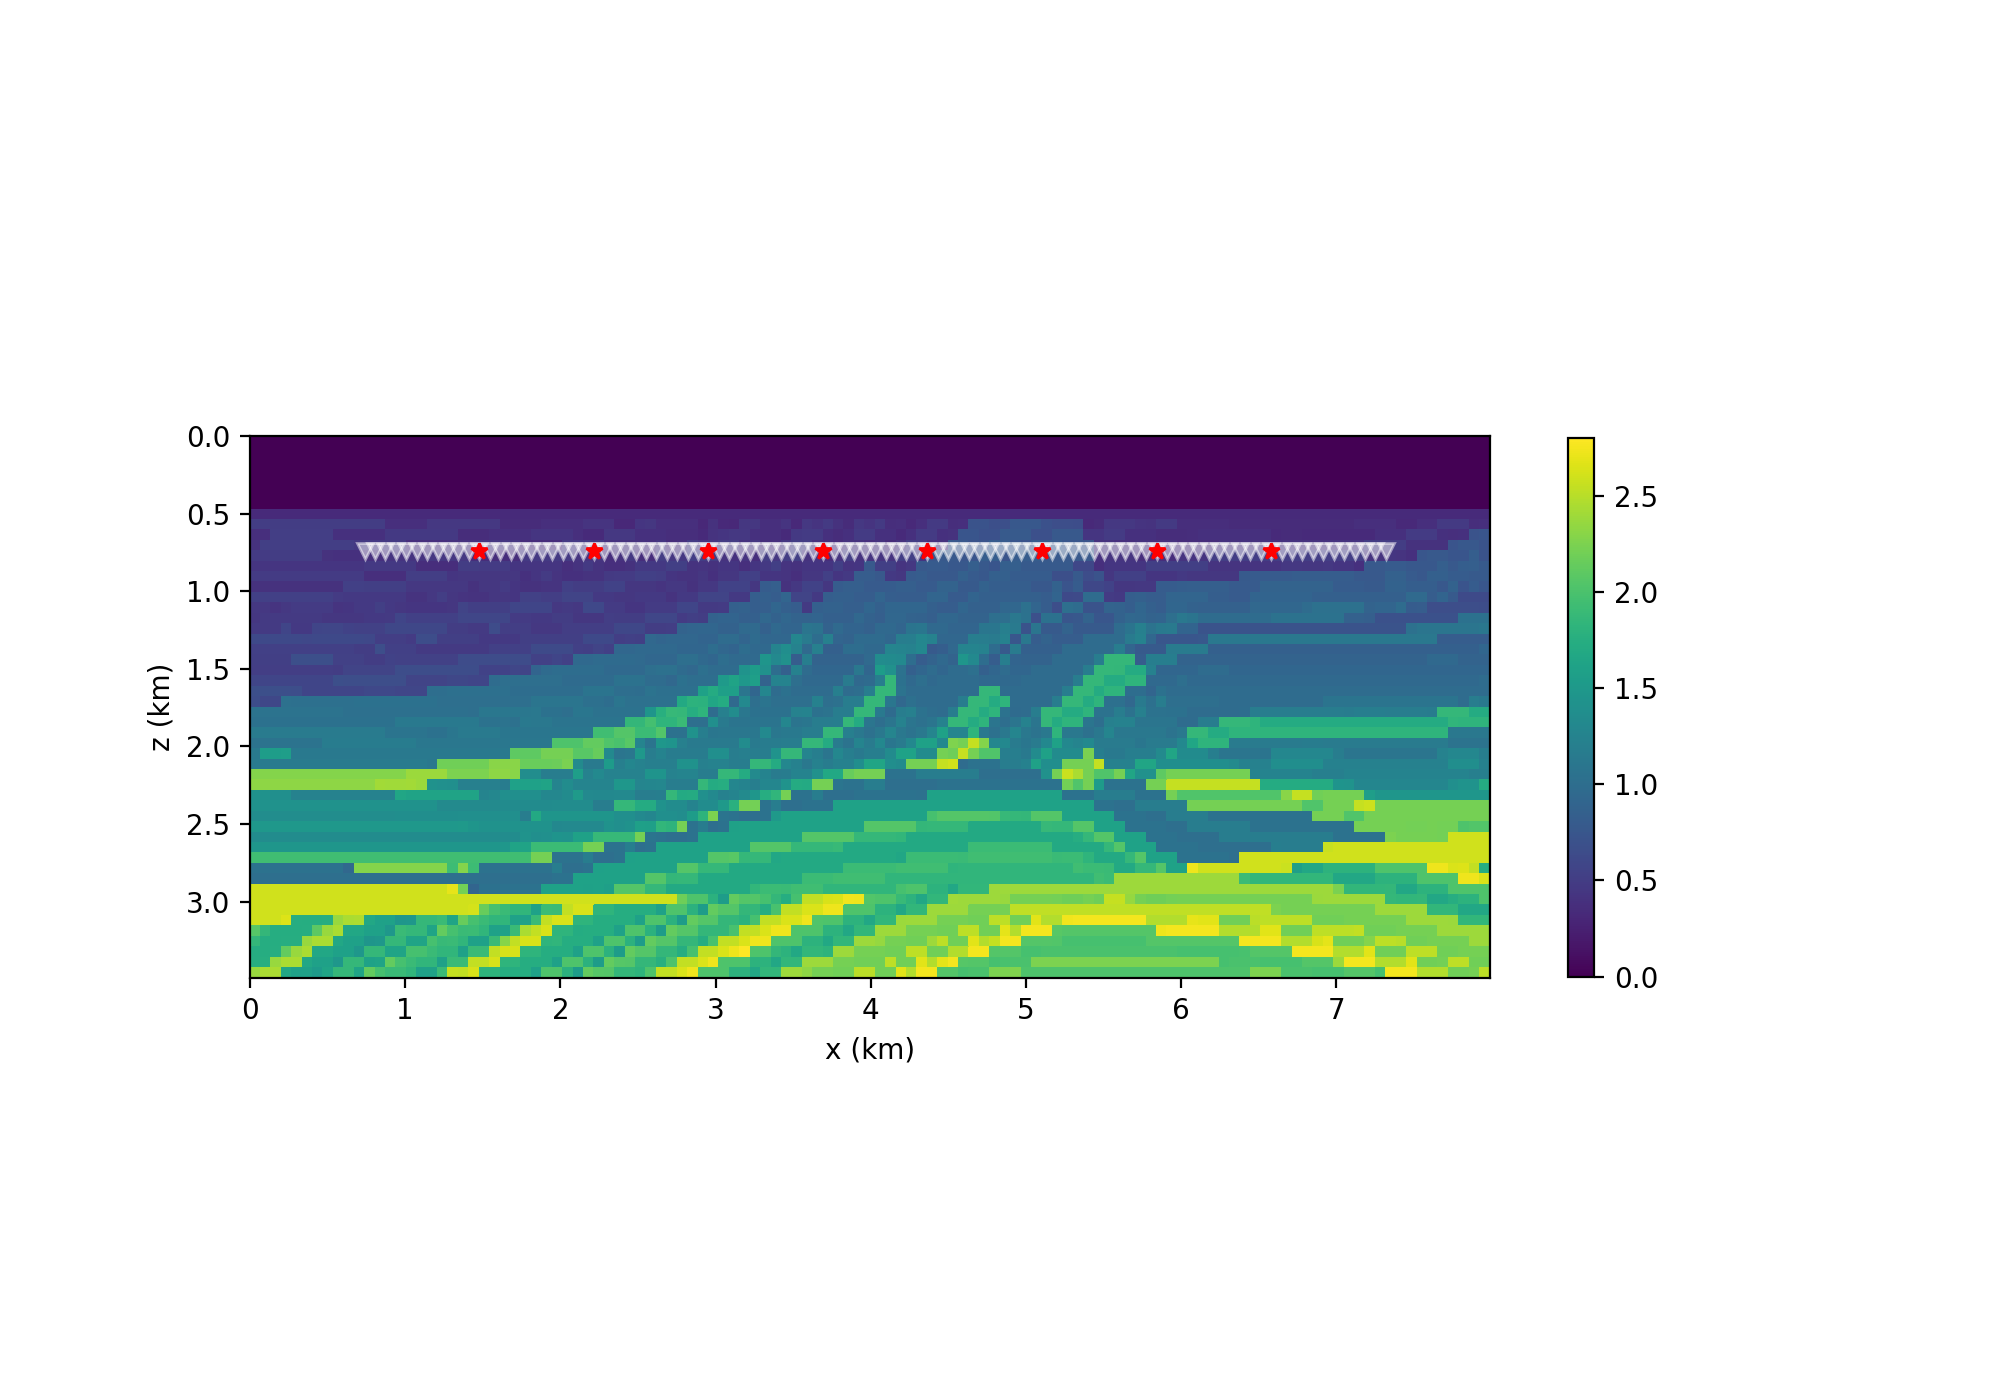

In [82]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vs'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-vs.png"))
plt.show()

<IPython.core.display.Javascript object>


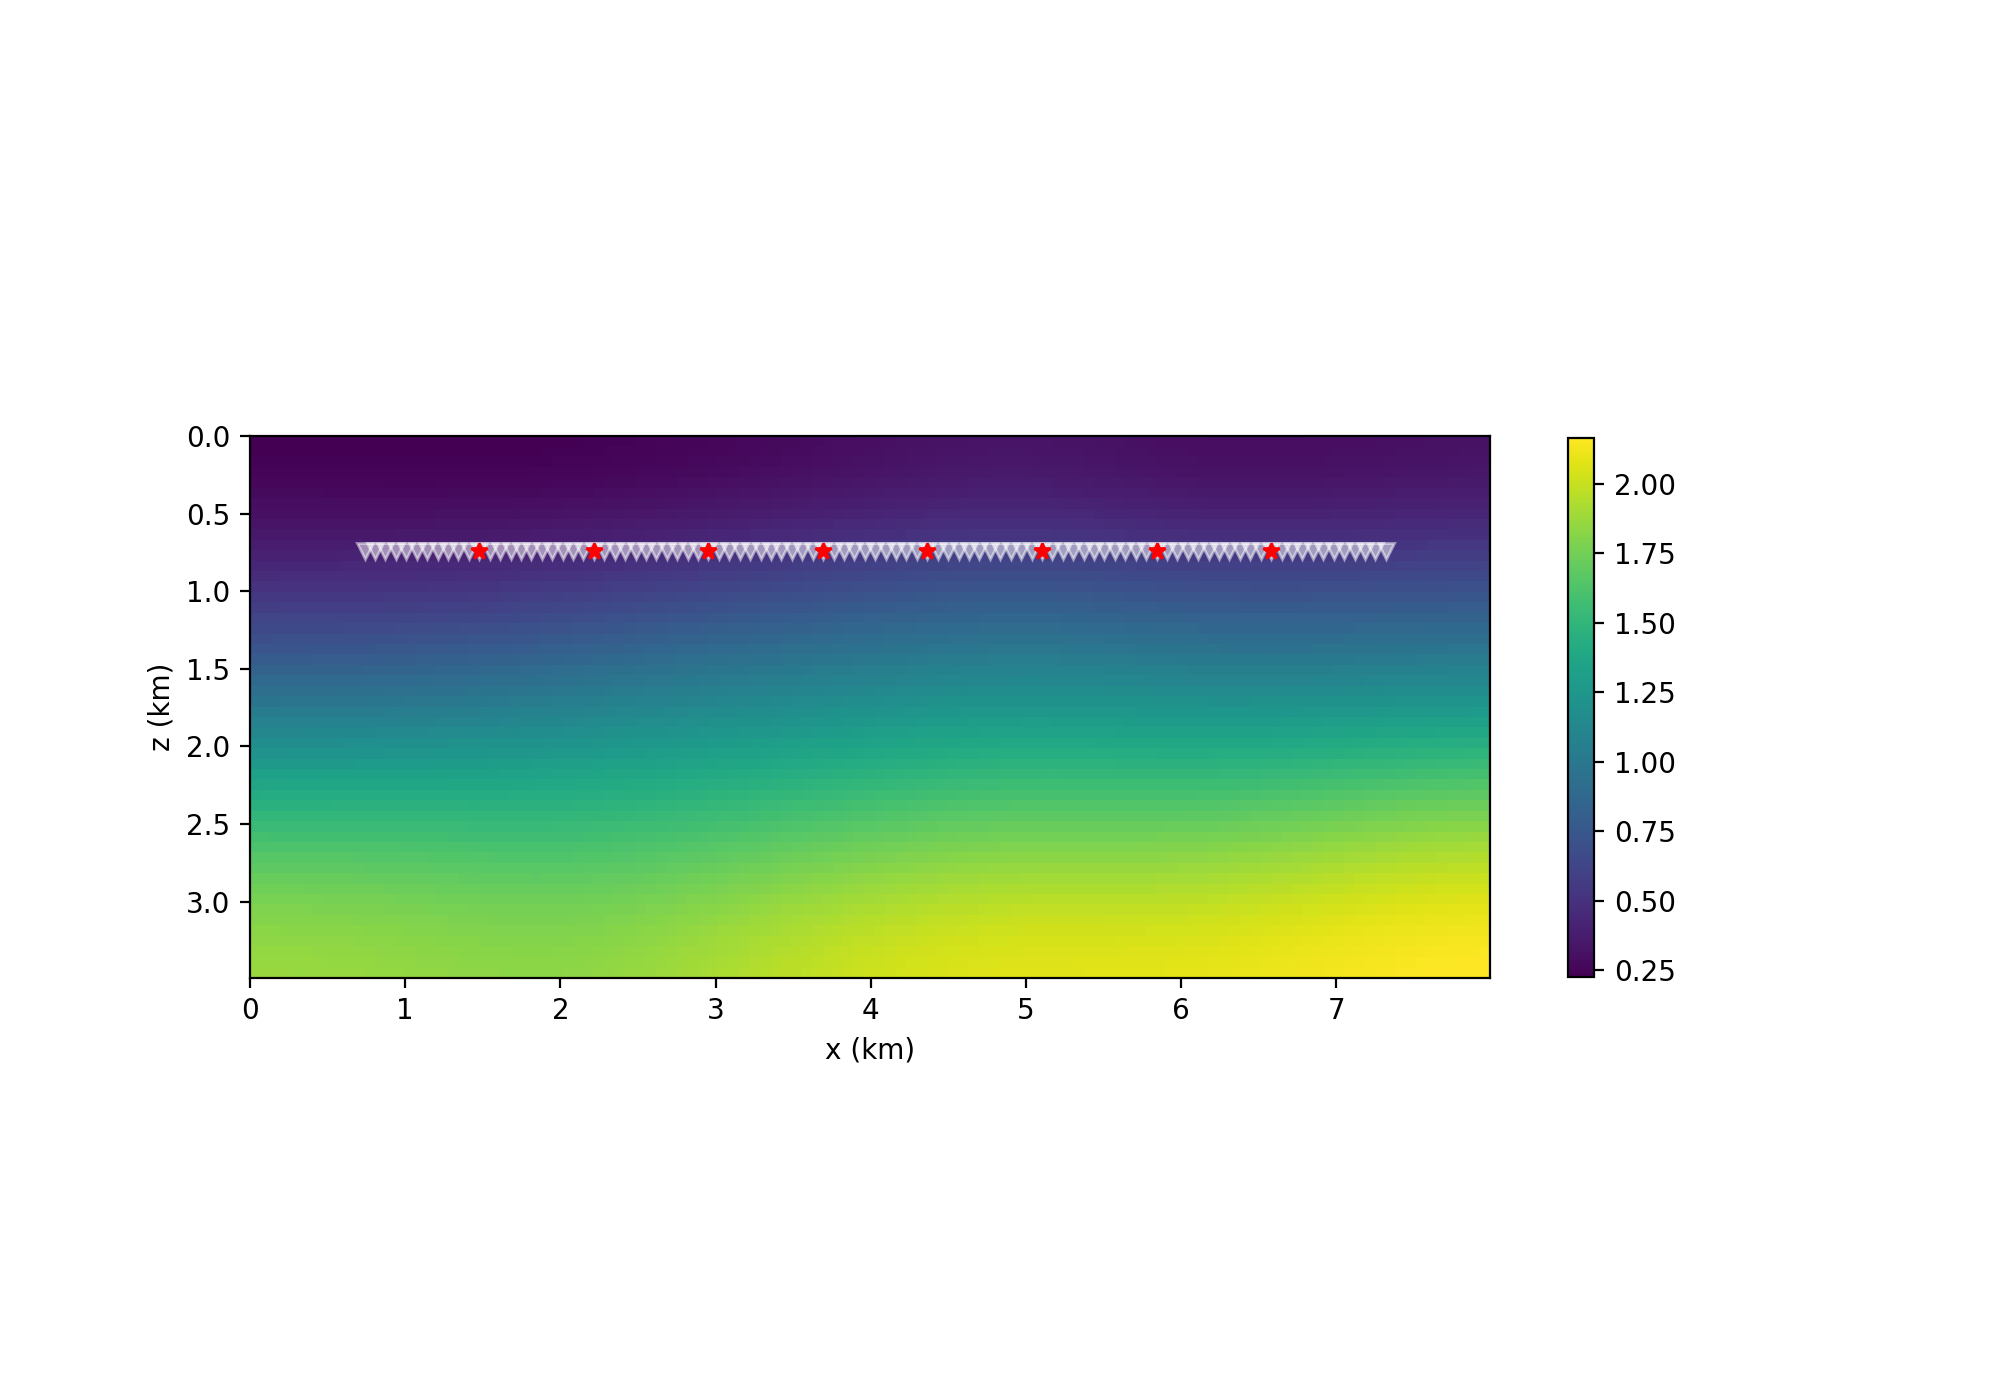

In [83]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['vs'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-smooth-vs.png"))
plt.show()

<IPython.core.display.Javascript object>


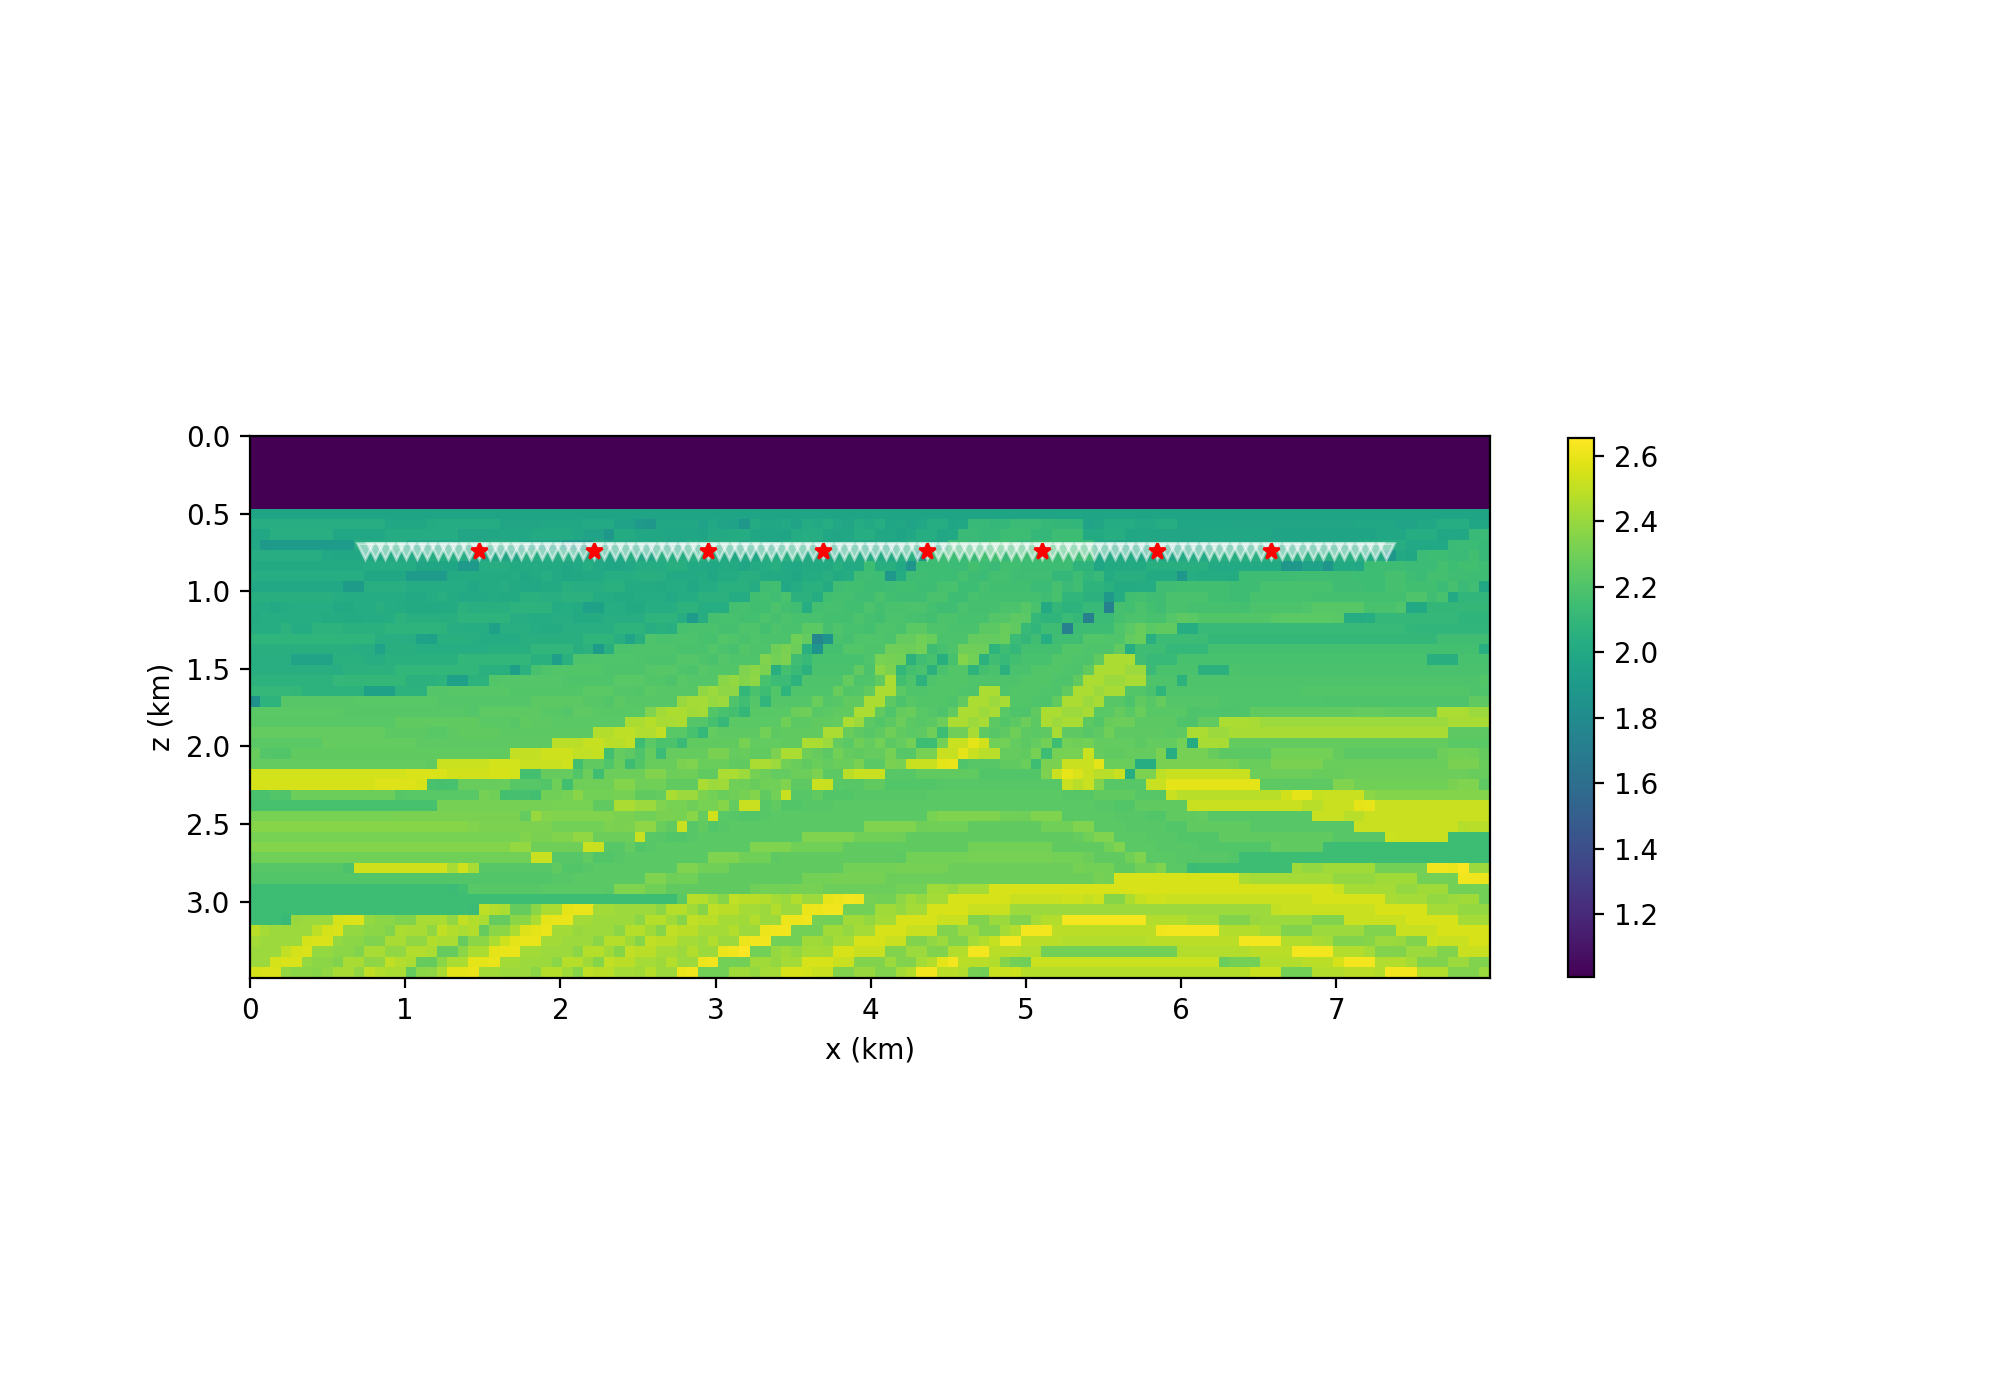

In [84]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['rho'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-rho.png"))
plt.show()

<IPython.core.display.Javascript object>


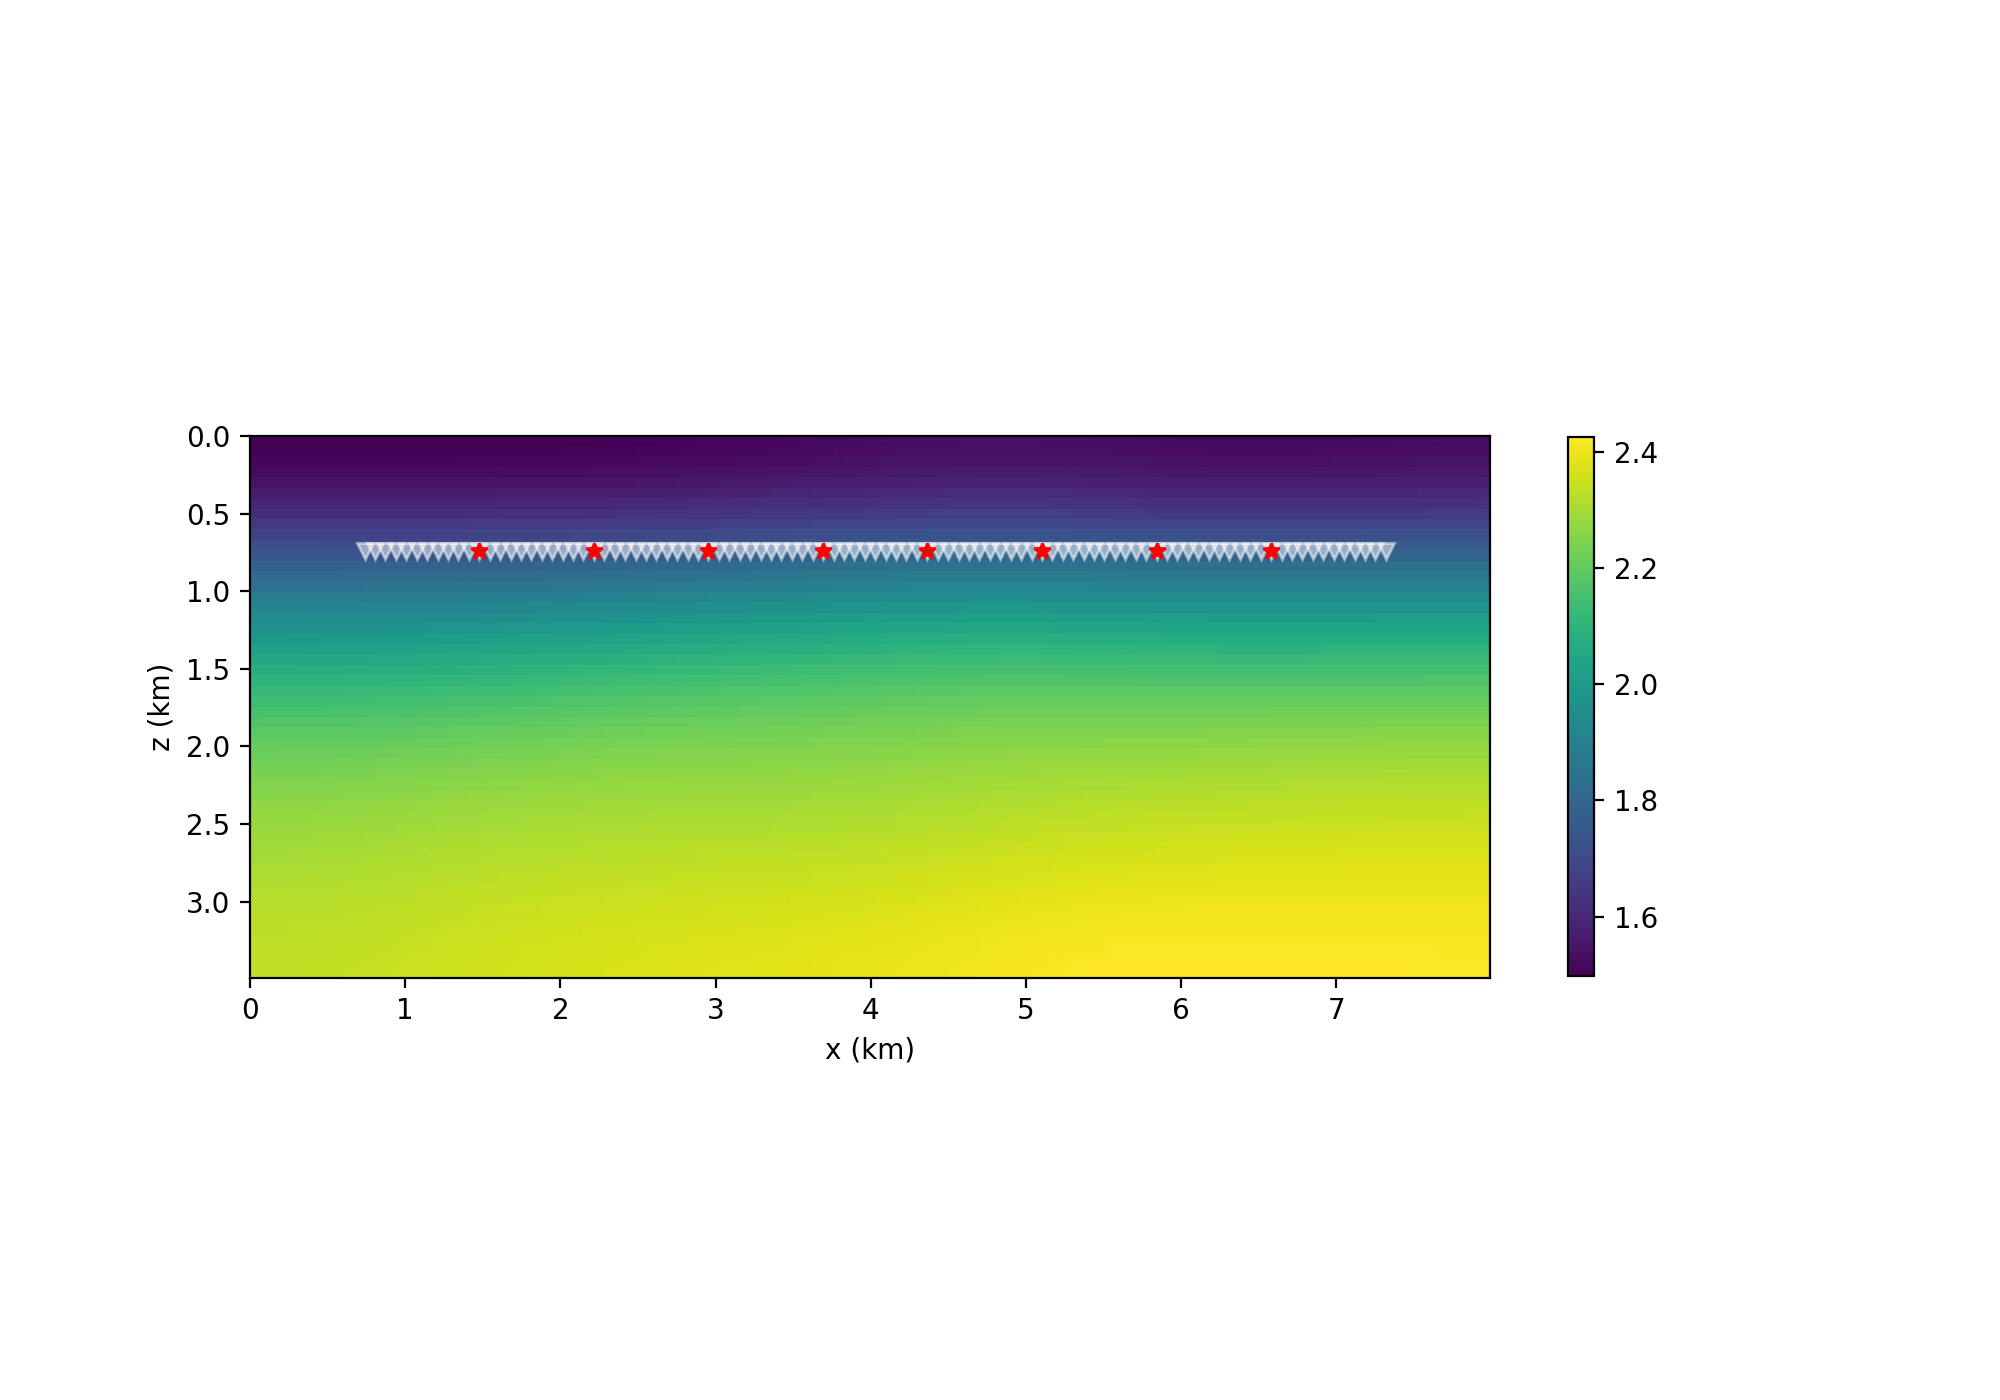

In [85]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['rho'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-smooth-rho.png"))
plt.show()

In [86]:
scipy.io.savemat(os.path.join(out_dir, 'marmousi2-model-true.mat'),
         {"vp" : model['vp'], 
         "vs" : model['vs'], 
         "rho" : model['rho'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})

In [87]:
scipy.io.savemat(os.path.join(out_dir, 'marmousi2-model-smooth.mat'),
         {"vp" : smooth_model['vp'], 
         "vs" : smooth_model['vs'], 
         "rho" : smooth_model['rho'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})